# Table of Contents

- [Imports](#imports)
- [Load data in](#load-data-in)
- [Modeling](#modeling)
- [Evaluation](#evaluation)
- [use ResNet50](#use-resnet50)
- [ResNet50 Evaluation](#resnet50-evaluation)

# Imports

In [14]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchmetrics
from torchmetrics import Recall, Precision
import torch.optim.lr_scheduler as lr_scheduler # Import the scheduler
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Load data in

In [2]:
# Compose transformations
''' train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(128),
    transforms.Resize((128, 128)),
]) '''

train_transforms = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(45),
  transforms.RandomAutocontrast(),
  transforms.ToTensor(),
  transforms.Resize((128, 128))
  ])

# Create Dataset using ImageFolder
dataset_train = ImageFolder(
    "data\clouds_train",
    transform=train_transforms,
)

dataloader_train = DataLoader(
  dataset_train, shuffle=True, batch_size=8
)


test_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((128, 128))
  ])
# Create Dataset using ImageFolder
dataset_test = ImageFolder(
    "data\clouds_test",
    transform=test_transforms,
)

dataloader_test = DataLoader(
  dataset_test, shuffle=True, batch_size=8
)

In [37]:
def denormalize(tensor, mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]):
    """
    Denormalize
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # x = x * std + mean
    return tensor

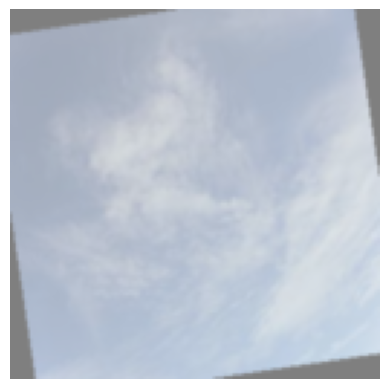

In [49]:

image, label = next(iter(dataloader_train))
# Select the first image in the batch
img = denormalize(image[0])  # shape: [C, H, W]

# Convert to [H, W, C] for matplotlib
img = img.permute(1, 2, 0)

# Display the image
plt.imshow(img)
plt.axis('off')  # optional: turn off axis
plt.show()

# Modeling

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Define feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.2),
            nn.Flatten(),
        )
        self.classifier = nn.Linear(64*32*32, num_classes)

    def forward(self, x):
        # Pass input through feature extractor and classifier
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [5]:
# Define the model
net = Net(num_classes = 7).to(device)
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr = 0.001)
# Define the learning rate scheduler
# StepLR decays the learning rate by gamma every step_size epochs
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(50):
    running_loss = 0.0
    # Iterate over training batches
    for images, labels in dataloader_train:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")
    # Step the scheduler at the end of each epoch
    # scheduler.step()
    # print(f"Learning Rate: {optimizer.param_groups[0]['lr']}")

Epoch 1, Loss: 1.9074
Epoch 2, Loss: 1.6376
Epoch 3, Loss: 1.5654
Epoch 4, Loss: 1.4269
Epoch 5, Loss: 1.4464
Epoch 6, Loss: 1.3486
Epoch 7, Loss: 1.2518
Epoch 8, Loss: 1.2837
Epoch 9, Loss: 1.2831
Epoch 10, Loss: 1.2921
Epoch 11, Loss: 1.1707
Epoch 12, Loss: 1.1941
Epoch 13, Loss: 1.2242
Epoch 14, Loss: 1.1788
Epoch 15, Loss: 1.1147
Epoch 16, Loss: 1.1282
Epoch 17, Loss: 1.1206
Epoch 18, Loss: 1.0968
Epoch 19, Loss: 1.2073
Epoch 20, Loss: 1.0247
Epoch 21, Loss: 1.0544
Epoch 22, Loss: 0.9415
Epoch 23, Loss: 0.9809
Epoch 24, Loss: 0.9738
Epoch 25, Loss: 0.9089
Epoch 26, Loss: 0.9682
Epoch 27, Loss: 0.9932
Epoch 28, Loss: 0.8526
Epoch 29, Loss: 0.9607
Epoch 30, Loss: 0.8536
Epoch 31, Loss: 0.8889
Epoch 32, Loss: 0.7831
Epoch 33, Loss: 0.8597
Epoch 34, Loss: 0.8436
Epoch 35, Loss: 0.8429
Epoch 36, Loss: 0.7581
Epoch 37, Loss: 0.7654
Epoch 38, Loss: 0.7132
Epoch 39, Loss: 0.8262
Epoch 40, Loss: 0.7164
Epoch 41, Loss: 0.7034
Epoch 42, Loss: 0.6785
Epoch 43, Loss: 0.6516
Epoch 44, Loss: 0.66

# Evaluation

In [6]:
metric_precision = Precision(task='multiclass', num_classes=7, average='micro').to(device)
metric_recall = Recall(task='multiclass', num_classes=7, average='micro').to(device)

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.6111111044883728
Recall: 0.6111111044883728


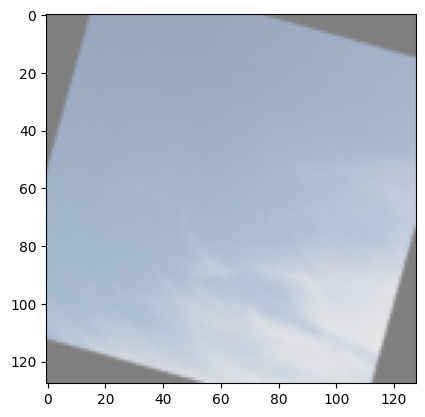

Prediction: 0
Label: 0


In [56]:
# make a sample prediction
image, label = next(iter(dataloader_test))

# Select the first image from the batch for visualization
# This part is for visualization only and does not affect the tensor passed to the network
display_image = denormalize(image[0].clone()).permute(1, 2, 0) # Apply denormalize and permute to a single image
plt.imshow(display_image)
plt.show()

# use net model for prediction
# Pass the original image tensor with dimensions (batch_size, channels, height, width)
output = net(image.to(device)) # Move the image batch to the correct device
_, pred = torch.max(output, 1)

# Assuming the batch size is 8, we'll print the first prediction and label
print(f"Prediction: {pred[0].item()}")
print(f"Label: {label[0].item()}")

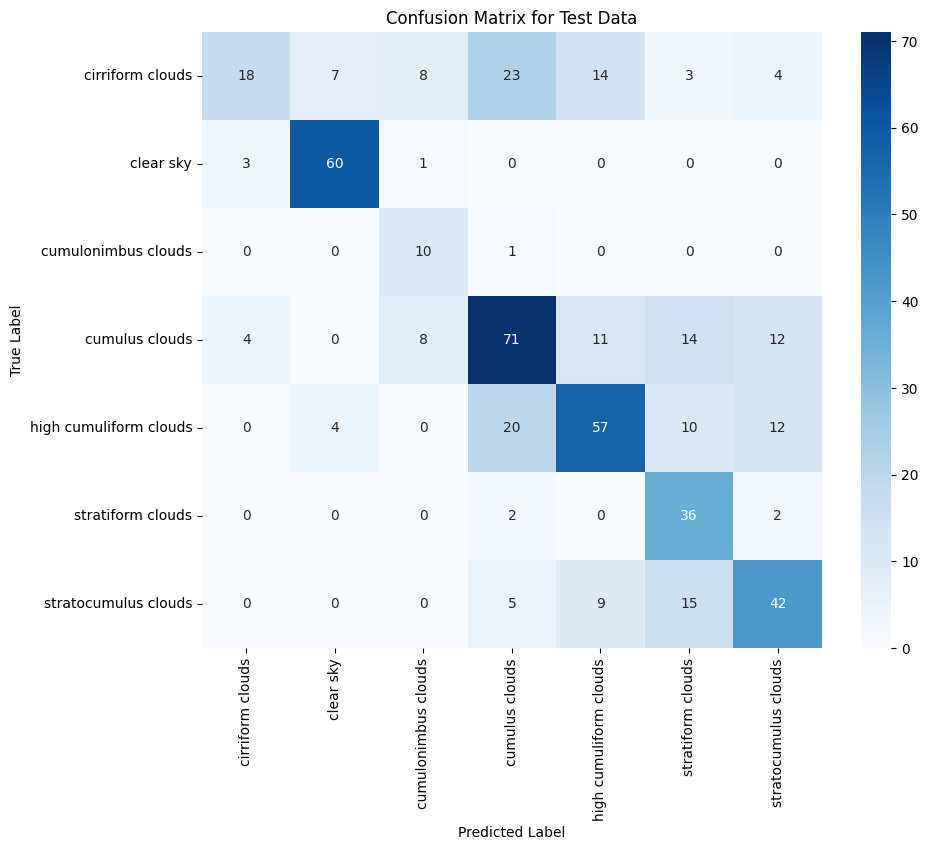

In [17]:
# make a cross tab for the test data
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_labels = []
all_preds = []

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Get class names from the dataset
class_names = dataset_test.classes

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Data')
plt.show()

# use ResNet50

In [7]:
from torchvision.models import resnet50, ResNet50_Weights

# Load the pre-trained ResNet50 model
model = resnet50(weights=ResNet50_Weights.DEFAULT,)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\mohamed mowina/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100.0%


In [8]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)

In [9]:
# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last block (e.g., layer4)
for param in model.layer4.parameters():
    param.requires_grad = True

# And the final classifier
for param in model.fc.parameters():
    param.requires_grad = True

# Optimizer for unfrozen layers
params_to_update = list(model.layer4.parameters()) + list(model.fc.parameters())
optimizer = optim.Adam(params_to_update, lr=0.0001)

In [10]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.001)

# Move the model to the device before training
model.to(device)

for epoch in range(20):
    model.train()
    running_loss = 0.0
    # Iterate over training batches
    for images, labels in dataloader_train:
        # Move data to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images) # Use 'model' instead of 'net'
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

    # Step the scheduler at the end of each epoch
    scheduler.step()
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']}")

Epoch 1, Loss: 1.6951
Learning Rate: 0.0001
Epoch 2, Loss: 1.0716
Learning Rate: 0.0001
Epoch 3, Loss: 0.7104
Learning Rate: 0.0001
Epoch 4, Loss: 0.5372
Learning Rate: 0.0001
Epoch 5, Loss: 0.4764
Learning Rate: 1.0000000000000001e-07
Epoch 6, Loss: 0.4058
Learning Rate: 1.0000000000000001e-07
Epoch 7, Loss: 0.5106
Learning Rate: 1.0000000000000001e-07
Epoch 8, Loss: 0.4364
Learning Rate: 1.0000000000000001e-07
Epoch 9, Loss: 0.4630
Learning Rate: 1.0000000000000001e-07
Epoch 10, Loss: 0.3958
Learning Rate: 1.0000000000000002e-10
Epoch 11, Loss: 0.4290
Learning Rate: 1.0000000000000002e-10
Epoch 12, Loss: 0.4414
Learning Rate: 1.0000000000000002e-10
Epoch 13, Loss: 0.4206
Learning Rate: 1.0000000000000002e-10
Epoch 14, Loss: 0.3750
Learning Rate: 1.0000000000000002e-10
Epoch 15, Loss: 0.4405
Learning Rate: 1.0000000000000002e-13
Epoch 16, Loss: 0.3911
Learning Rate: 1.0000000000000002e-13
Epoch 17, Loss: 0.4591
Learning Rate: 1.0000000000000002e-13
Epoch 18, Loss: 0.4294
Learning Rate

# ResNet50 Evaluation

In [12]:
test_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((128, 128))
  ])
# Create Dataset using ImageFolder
dataset_test = ImageFolder(
    "data\clouds_test",
    transform=test_transforms, # Use test_transforms here
)

dataloader_test = DataLoader(
  dataset_test, shuffle=True, batch_size=1
)

In [13]:
metric_precision = Precision(task='multiclass', num_classes=7, average='micro').to(device)
metric_recall = Recall(task='multiclass', num_classes=7, average='micro').to(device)

model.eval() # Use 'model' instead of 'net'
metric_precision.reset()
metric_recall.reset()
with torch.no_grad():
    for images, labels in dataloader_test:
        # Move data to the device
        images, labels = images.to(device), labels.to(device)

        outputs = model(images) # Use 'model' instead of 'net'
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.903292179107666
Recall: 0.903292179107666


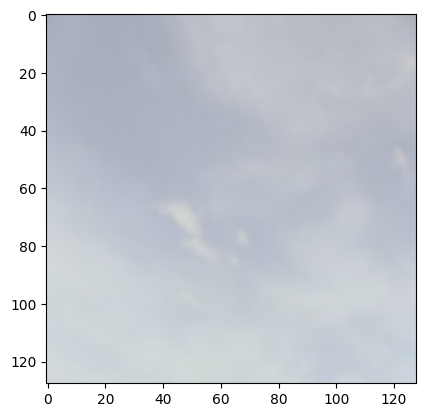

Prediction: 0
Label: 0


In [34]:
# make a sample prediction
image, label = next(iter(dataloader_test))

# Move image to the device for prediction
image_on_device = image.to(device)

# Display the image (using a temporary denormalized and permuted version)
# This part is for visualization only and does not affect the tensor passed to the network
display_image = denormalize(image.clone()).squeeze().permute(1, 2, 0)
plt.imshow(display_image)
plt.show()

# use model for prediction
# Pass the original image tensor with dimensions (batch_size, channels, height, width)
output = model(image_on_device) # Use 'model' instead of 'net'
_, pred = torch.max(output, 1)
print(f"Prediction: {pred.item()}")
print(f"Label: {label.item()}")

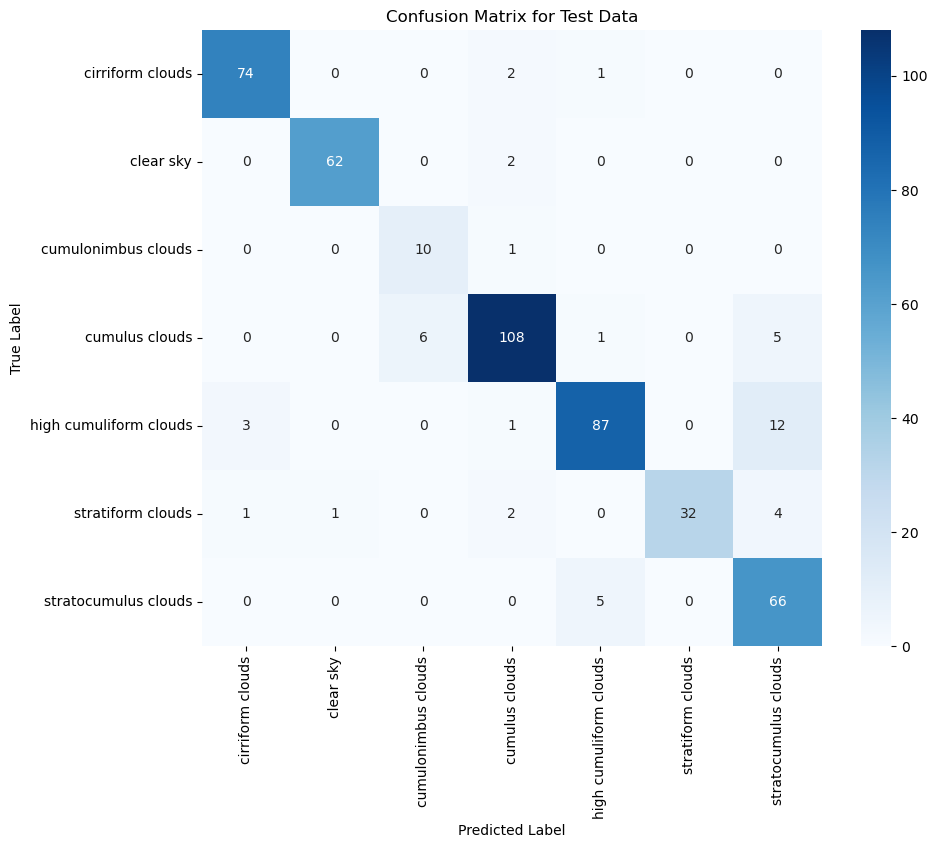

Precision: 0.903292179107666
Recall: 0.903292179107666


In [15]:
# make a cross tab for the test data
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_labels = []
all_preds = []

model.eval() # Use 'model' instead of 'net'
metric_precision.reset() # Reset metrics before evaluation
metric_recall.reset() # Reset metrics before evaluation
with torch.no_grad():
    for images, labels in dataloader_test:
        # Move data to the device
        images, labels = images.to(device), labels.to(device)

        outputs = model(images) # Use 'model' instead of 'net'
        _, preds = torch.max(outputs, 1)
        # Accumulate predictions and labels for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        # Update metrics
        metric_precision(preds, labels)
        metric_recall(preds, labels)


# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Get class names from the dataset
class_names = dataset_test.classes

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Data')
plt.show()

# Compute final precision and recall after the loop
precision = metric_precision.compute()
recall = metric_recall.compute()
print(f"Precision: {precision}")
print(f"Recall: {recall}")